In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import openpyxl
%matplotlib inline

In [2]:
import os

In [13]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
refs_dir = TOP + 'references/'

## Visualising ELSIE and LRI datasets through ToxPrints

In [4]:
elsie = pd.read_excel(raw_dir+'ELISE_270919.xlsx', sheet_name = 'ELISE')

In [6]:
#print(elise_orig.DTXSID.unique())
#elise_orig.QSAR_READY_SMILES.nunique()
elsie.QSAR_READY_SMILES.count()

420

In [7]:
elise_txps = pd.read_excel(raw_dir+'ELISE_270919.xlsx', sheet_name = 'ELISE_txpts_CORINA_270919')

In [8]:
elise_txps.SMILES.count()

429

In [9]:
elise_txps[elise_txps['atom:element_main_group'].isnull()]

,Record number,Compound history,CASRN,SMILES,FOUND_BY,DTXSID,QSAR_READY_SMILES,NAME,STRUCTURE_WARNING,atom:element_main_group,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene


In [10]:
elise_txps.shape

(429, 738)

#### Translation of 729 ToxPrints into Level 2 condensed ToxPrints for profiling purposes

In [11]:
elise_txps['atom:element_main_group'].value_counts()

0    428
1      1
Name: atom:element_main_group, dtype: int64

In [14]:
txpts = pd.read_csv(refs_dir+'toxprint_V2.0_r711_5Levels.csv')

In [15]:
level2_dict = {}
for x,y in txpts.groupby(['Level 2 full']):
    k = [e for e in y['Level 2 full'] if e!= ' '][0]
    v = set(y['ToxPrint_chemotype_name (original)'])
    level2_dict[k]=v

In [16]:
elise_txps.columns.get_loc('atom:element_main_group')

9

In [17]:
elise_cols = elise_txps.columns.tolist()[9:]

In [18]:
elise_txps = elise_txps.replace(0, np.nan)

In [19]:
#elise_txps = elise_txps.dropna(how='all')

In [20]:
elise_tps_long = pd.melt(elise_txps, id_vars='DTXSID',value_vars= elise_cols)

In [21]:
elise_tps_long.rename(columns={'variable': 'toxprint'}, inplace=True)

In [22]:
tag = {e:k for e in elise_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [23]:
elise_tps_long['aggregate_toxprint'] = elise_tps_long['toxprint']

In [24]:
elise_tps_long['aggregate_toxprint'].replace(tag , inplace = True)

In [25]:
elise_tps_long = elise_tps_long.dropna(how = 'any', axis = 0)

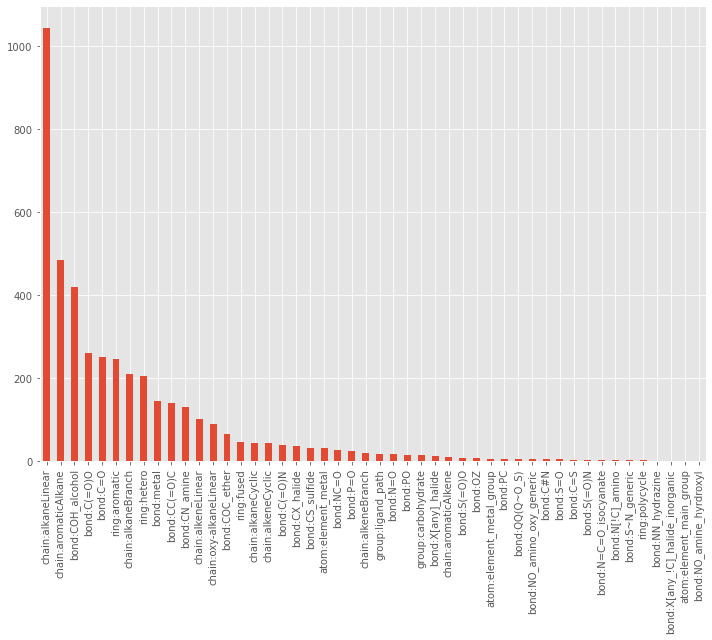

In [26]:
plt.style.use('ggplot')
plt.figure(figsize= (10,9))
elise_tps_long.aggregate_toxprint.value_counts().plot.bar()
plt.tight_layout()

In [27]:
elise_bar = elise_tps_long.aggregate_toxprint.value_counts().reset_index()

In [28]:
elise_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)

<AxesSubplot:xlabel='count', ylabel='Txp'>

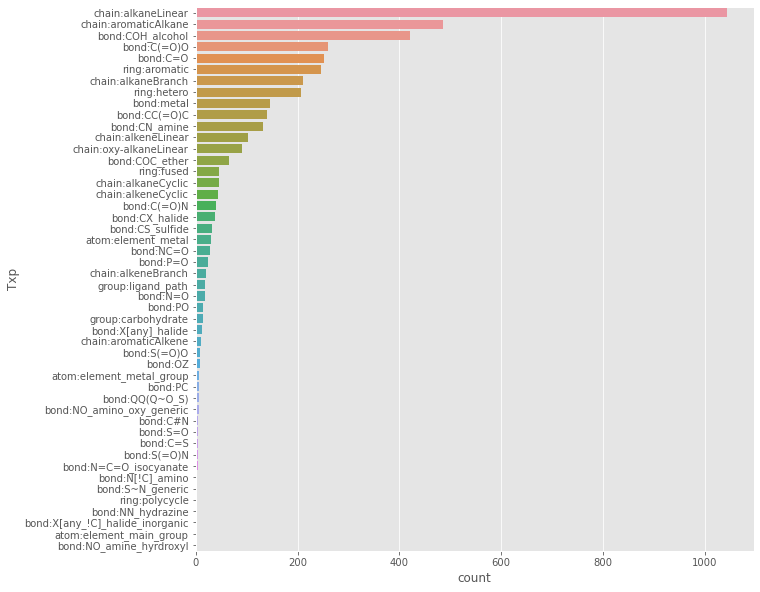

In [29]:

plt.figure(figsize = (10,10))
sns.barplot(x = elise_bar['count'], y = elise_bar['Txp'], data = elise_bar)


In [30]:
df_chunk = pd.read_csv(raw_dir+'lri_txps_140220.csv', chunksize=1000)

chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in df_chunk:  
    # perform data filtering 
    #chunk_filter = chunk_preprocessing(chunk)
    
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
lri_tps = pd.concat(chunk_list)


In [31]:
lri_tps.shape

(45038, 732)

In [32]:
lri_tps.head()

,M_NAME,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,...,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene,M_COMPOUND_HISTORY_[STRING],M_CORINA_SYMPHONY_ERRORS_[STRING]
0,DTXSID6020561,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Original compound,No errors
1,DTXSID9020453,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Original compound,No errors
2,DTXSID3034456,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Original compound,No errors
3,DTXSID2024242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Original compound,No errors
4,DTXSID4032376,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Original compound,No errors


In [33]:
lri_tps.rename(columns = {'M_NAME' 	:'DTXSID'},inplace = True)

In [34]:
lri_tps['atom:element_main_group'].value_counts(dropna = False)

0    45037
1        1
Name: atom:element_main_group, dtype: int64

In [35]:
lri_tps = lri_tps.replace(0, np.nan)
#lri_tps = lri_tps.dropna(how='all')


In [36]:
lri_tps['atom:element_main_group'].value_counts()

1.0    1
Name: atom:element_main_group, dtype: int64

In [37]:
lri_tps.head()

,DTXSID,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,...,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene,M_COMPOUND_HISTORY_[STRING],M_CORINA_SYMPHONY_ERRORS_[STRING]
0,DTXSID6020561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original compound,No errors
1,DTXSID9020453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original compound,No errors
2,DTXSID3034456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original compound,No errors
3,DTXSID2024242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original compound,No errors
4,DTXSID4032376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original compound,No errors


In [38]:
lri_cols = lri_tps.columns.tolist()[1:-2]

In [39]:
#lri_cols


In [40]:
lri_tps_long = pd.melt(lri_tps, id_vars='DTXSID',value_vars= lri_cols)

In [41]:
lri_tps_long.head()

,DTXSID,variable,value
0,DTXSID6020561,atom:element_main_group,NaN
1,DTXSID9020453,atom:element_main_group,NaN
2,DTXSID3034456,atom:element_main_group,NaN
3,DTXSID2024242,atom:element_main_group,NaN
4,DTXSID4032376,atom:element_main_group,NaN


In [42]:
lri_tps_long = lri_tps_long.dropna(axis = 0, how = 'any')

In [43]:
lri_tps_long.shape

(595132, 3)

In [44]:
lri_tps_long.rename(columns={'variable': 'toxprint'}, inplace=True)

In [45]:
tag2 = {e:k for e in lri_tps_long['toxprint'] for k,v in level2_dict.items() if e in v}

In [46]:
lri_tps_long['aggregate_toxprint'] = lri_tps_long['toxprint']

In [47]:
lri_tps_long['aggregate_toxprint'].replace(tag2 , inplace = True)

In [48]:
lri_bar = lri_tps_long.aggregate_toxprint.value_counts().reset_index()

In [49]:
lri_bar.rename(columns = {'index' : 'Txp', 'aggregate_toxprint' : 'count'}, inplace = True)

In [50]:
lri_bar.head()

,Txp,count
0,ring:hetero,74239
1,chain:alkaneLinear,65599
2,bond:CN_amine,53708
3,bond:COH_alcohol,43410
4,chain:aromaticAlkane,39827


<AxesSubplot:xlabel='count', ylabel='Txp'>

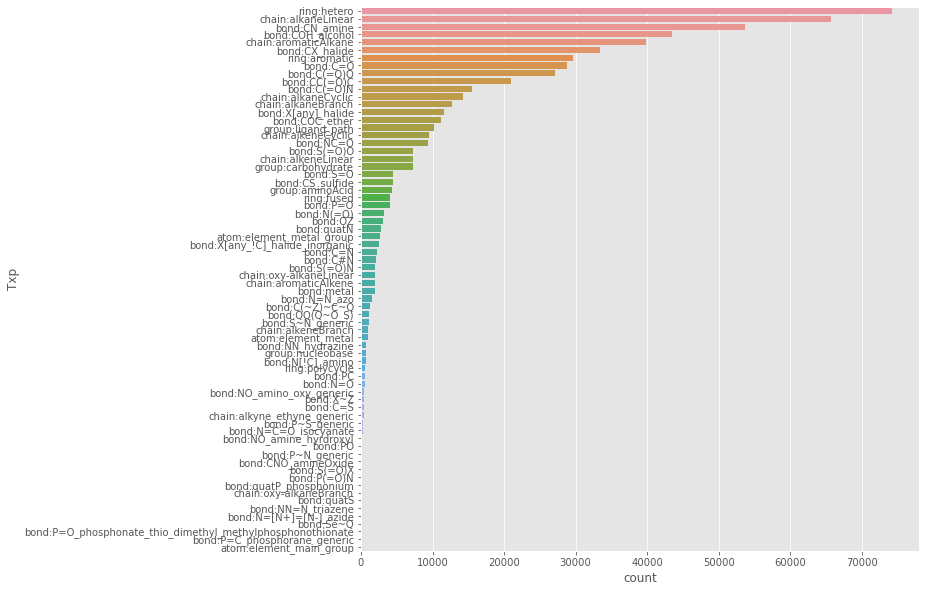

In [51]:

plt.figure(figsize = (10,10))
sns.barplot(y = lri_bar['Txp'], x = lri_bar['count'], data = lri_bar)

In [52]:
lri_elise = pd.merge(lri_bar, elise_bar, on = 'Txp' , how = 'outer')

In [53]:
lri_elise.rename(columns = {'count_x': 'LRI_count', 'count_y': 'ELSIE_count'}, inplace = True)

In [54]:
lri_elise.head()

,Txp,LRI_count,ELSIE_count
0,ring:hetero,74239,206.0
1,chain:alkaneLinear,65599,1044.0
2,bond:CN_amine,53708,132.0
3,bond:COH_alcohol,43410,421.0
4,chain:aromaticAlkane,39827,485.0


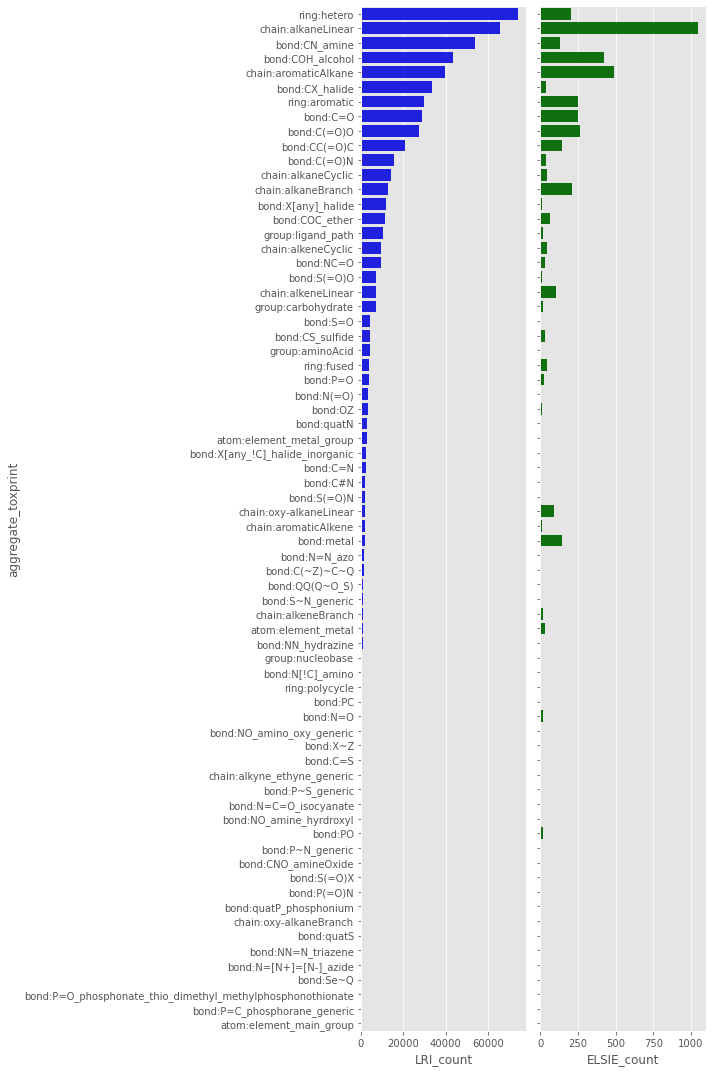

In [55]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,15), sharey = True)


sns.barplot(x = 'LRI_count', y = 'Txp', color = 'b',label = "lri", data = lri_elise, ax=ax1)
sns.barplot(x = 'ELSIE_count', y = 'Txp', color = 'g',label = "Elise", data = lri_elise, ax = ax2)

ax1.set_ylabel('aggregate_toxprint')
ax2.set_ylabel('')


ax1.set_xlabel('LRI_count')
ax2.set_xlabel('ELSIE_count')
plt.tight_layout()

f.savefig(figures_dir+'toxprints_comparison_211021.png', dpi = 300)

In [56]:
elise_df = pd.read_excel(raw_dir+'ELISE_270919.xlsx', sheet_name = 'ELISE_txpts_CORINA_270919')

In [57]:
elise_txps = elise_txps.set_index('DTXSID')

In [58]:
new_elise = elise_txps.iloc[:,8:]

In [59]:
new_elise.head()

,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID4029355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTXSID4020240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTXSID0021961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTXSID6027428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTXSID2021781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#elise_df_new = elise_df.set_index('DTXSID')

In [61]:
#new_elise = elise_df_new.iloc[:,8:]

In [62]:
new_elise['Source']= 'ELSIE'

In [63]:
lri_tps.drop(['M_COMPOUND_HISTORY_[STRING]', 'M_CORINA_SYMPHONY_ERRORS_[STRING]'],axis = 1,  inplace = True)

In [64]:
lri_tps.head()

,DTXSID,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
0,DTXSID6020561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID9020453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DTXSID3034456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DTXSID2024242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DTXSID4032376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
lri_tps_df = lri_tps.set_index('DTXSID')

In [66]:
lri_tps_df['Source'] = 'LRI'

In [67]:
lri_elise_tps = pd.concat([lri_tps_df, new_elise],axis = 0)

In [68]:
lri_elise_tps.head()

,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene,Source
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID6020561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRI
DTXSID9020453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRI
DTXSID3034456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRI
DTXSID2024242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRI
DTXSID4032376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LRI


In [69]:
lri_elise_tps = lri_elise_tps.fillna(0)

In [70]:
#lri_elise_tps.to_csv(processed_dir+'lri_elise_tps_df.csv')

#### Investigating means of visualising the 729 ToxPrints into 2-3 Dimensions - exploration of t-TSNE approaches

In [71]:
lri_elise_tps.iloc[:,0:729].head()

,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID6020561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID9020453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID3034456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID2024242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID4032376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
from sklearn.feature_selection import VarianceThreshold

In [73]:
sel = VarianceThreshold(threshold = (0*(1-0)))
X = sel.fit_transform(lri_elise_tps.iloc[:,0:729])

In [74]:
X_df = lri_elise_tps.iloc[:,0:729][lri_elise_tps.iloc[:,0:729].columns[sel.get_support(indices=True)]]

In [75]:
X_df1 = pd.concat([X_df,lri_elise_tps.iloc[:,729]],axis =1)

In [76]:
X_df1.Source.value_counts()

LRI      45038
ELSIE      429
Name: Source, dtype: int64

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_df1.iloc[:,:600], X_df1.iloc[:,600], test_size=0.1, stratify=X_df1.iloc[:,600])

In [79]:
y_test.head()

DTXSID
DTXSID80861570    LRI
DTXSID9065314     LRI
DTXSID6042078     LRI
DTXSID7045368     LRI
DTXSID9027491     LRI
Name: Source, dtype: object

In [80]:
from sklearn.manifold import TSNE

In [81]:
model_txps = TSNE(learning_rate = 200)

In [82]:
tsne_features = model_txps.fit_transform(X_test)

In [83]:
tsne_df=pd.concat([pd.DataFrame(tsne_features, index = X_test.index, columns = ['tsne_x', 'tsne_y']), y_test],axis =1)

In [84]:
tsne_df.head()

,tsne_x,tsne_y,Source
DTXSID,,,
DTXSID80861570,50.131172,-46.706604,LRI
DTXSID9065314,-65.145851,31.798206,LRI
DTXSID6042078,21.630335,42.067879,LRI
DTXSID7045368,-9.855927,51.791370,LRI
DTXSID9027491,-67.206993,9.516957,LRI


In [86]:
#tsne_df.to_csv(processed_dir+'TSNE_df_test.csv')

Text(0, 0.5, 'tsne_y')

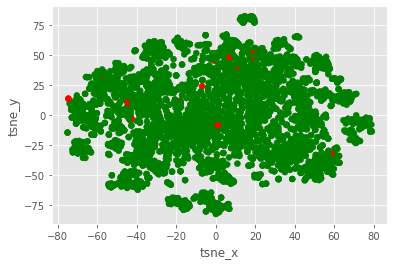

In [87]:
#colors = ['#2300A8', '#00A658']
#categories = tsne_df.Source.apply(lambda x: 1 if x == 'LRI' else 0)
color= ['red' if l == 'ELSIE' else 'green' for l in tsne_df['Source']]
fig, ax = plt.subplots()

ax.scatter(tsne_df['tsne_x'], tsne_df['tsne_y'],c =color)
ax.set_xlabel('tsne_x')
ax.set_ylabel('tsne_y')
#ax.legend()


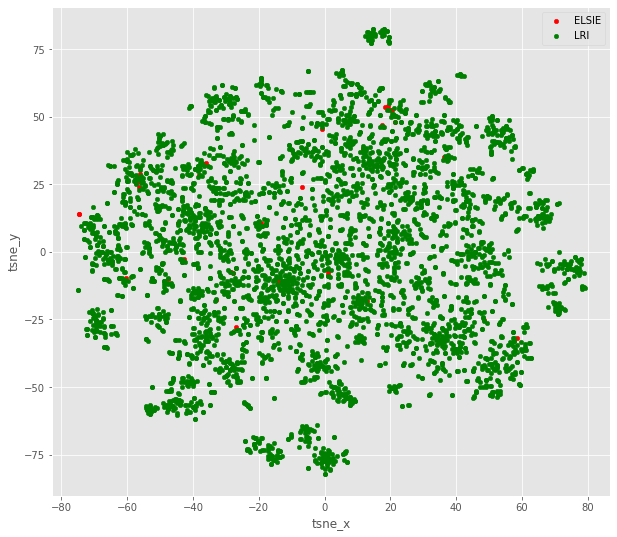

In [88]:
fig, ax = plt.subplots(figsize = (10,9))

colors = {'ELSIE':'red','LRI':'green' }

grouped = tsne_df.groupby('Source')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tsne_x', y='tsne_y', label=key, color=colors[key])
#plt.title('2D Visualisation of the ELSIE vs LRI Landscape')
plt.savefig(figures_dir+'TxP_2D_Landscape_211021.png', dpi = 300)

#### Previous analysis of exploring PCA approaches but v little variance explained in the first few principal components

In [182]:
X = elise_df.iloc[:,9:].values

In [183]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [184]:
from sklearn.preprocessing import StandardScaler

In [211]:
X_std = StandardScaler().fit_transform(X)

/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [212]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00233645 -0.00577028  0.         ...  0.          0.
   0.        ]
 [-0.00577028  1.00233645  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [213]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))


NumPy covariance matrix: 
[[ 1.00233645 -0.00577028  0.         ...  0.          0.
   0.        ]
 [-0.00577028  1.00233645  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [217]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)


In [218]:
eig_vecs

array([[ 0.00578638+0.j, -0.00760714+0.j,  0.00518026+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [-0.0243137 +0.j,  0.00347203+0.j,  0.00253604+0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  0.        +0.j],
       ...,
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         1.        +0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  1.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.        +0.j,  0.        +0.j,  1.        +0.j]])

In [215]:
u,s,v = np.linalg.svd(X_std.T)

In [216]:
u

array([[ 5.78638329e-03, -7.60713809e-03, -5.18026194e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.43136993e-02,  3.47203164e-03, -2.53604181e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.43223107e-16,  1.98842678e-16,  1.57426155e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [219]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')


Everything ok!


In [108]:
# Make a list of (eigenvalue, eigenvector) tuples
#eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
#eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
#print('Eigenvalues in descending order:')
#for i in eig_pairs:
    #print(i[0])

/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/grace/anaconda3/envs/my-mordred/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


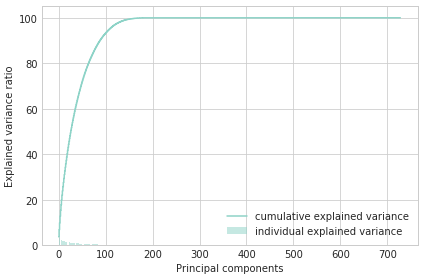

In [239]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(729), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(729), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()


In [240]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(729,1),
                      eig_pairs[1][1].reshape(729,1)))

print('Matrix W:\n', matrix_w)


Matrix W:
 [[ 0.00578638+0.j -0.00760714+0.j]
 [-0.0243137 +0.j  0.00347203+0.j]
 [ 0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j]]


In [241]:
Y = X_std.dot(matrix_w)


In [251]:
Y[:10]

array([[ 5.97646242+0.j,  4.71204697+0.j],
       [ 0.29856075+0.j, -0.99487399+0.j],
       [ 2.85484727+0.j,  1.24285565+0.j],
       [ 2.68950115+0.j,  6.44268971+0.j],
       [-0.62803087+0.j,  0.04008861+0.j],
       [ 1.58243257+0.j,  0.2758    +0.j],
       [ 1.49802016+0.j, -0.32177474+0.j],
       [ 1.12586524+0.j,  1.91690859+0.j],
       [-5.62626555+0.j, -2.46005383+0.j],
       [ 0.84221295+0.j, -0.11905907+0.j]])

In [248]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)


In [252]:
Y_sklearn[:10]

array([[-5.98022641,  4.72152574],
       [-0.29634036, -1.00985031],
       [-2.85877047,  1.23696431],
       [-2.69095003,  6.44285964],
       [ 0.62770173,  0.03903822],
       [-1.57654832,  0.27194695],
       [-1.49725565, -0.32425159],
       [-1.12631577,  1.91344241],
       [ 5.63008851, -2.45356008],
       [-0.8421492 , -0.12100528]])